# Generate a PPI train + validation set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action) and a Y2H test set from [HuRI](http://www.interactome-atlas.org/download)

`full size, 10:1, 31/10/22`

## prep

- March 2021 version of [APID](http://cicblade.dep.usal.es:8080/APID/init.action)
- interactomes for the 35 organisms listed as "with more than 500 interactions" only
- some organism datasets will be dropped later, so not fetching smaller sets is ok
- binary interactomes -> Level 2 -> `Q1` suffix
- not using *H. sapiens* for training -> `9606_*Q1.txt`


Preliminary loss from leaving out inter-species PPIs and the human interactome. First the number of IDs, then the number of PPIs:

| APID     |              ISI |            noISI |      loss |
|---------:|:----------------:|:----------------:|:---------:|
| w/ Human | 67'240 : 319'429 | 61'429 : 296'653 | .09 : .07 |
| no Human | 55'014 : 179'349 | 45'026 : 161'598 | .18 : .10 |
|     loss |    .18 : .44     |    .27 : .46     | .33 : .49 |

In [1]:
from __future__ import annotations

import os
import sys
import shutil
import importlib

from pathlib import Path

from dataclasses import dataclass, field

import numpy as np
import pandas as pd
from dataclass_wizard import JSONWizard

Mess around with paths because I'm running this a few times on different systems.

In [2]:
!which python
!pwd

/home/quirin/mambaforge/envs/ppi/bin/python
/home/quirin/PYTHON/ppi/ppi_data/template


In [3]:
if 'kaindl' in str(cwd := Path.cwd()):
    cwd = Path('/home/k/kaindll/ppi/ppi_data/template')

In [4]:
session = '8000'
session_dir = cwd.parent / 'results' / session

if not session_dir.is_dir():
    shutil.copytree(cwd, session_dir, symlinks=False,
                    ignore=shutil.ignore_patterns('*.ipynb', '*.png'),
                    dirs_exist_ok=True)
os.chdir(session_dir.resolve())
!pwd

/home/quirin/PYTHON/ppi/ppi_data/results/8000


In [5]:
from ppi_utils.cfg import Config, SamplingStrategy
from ppi_utils import api, extract, general, pairs, plot, reduce, proteome

from ppi_utils.api import *
from ppi_utils.extract import *
from ppi_utils.general import *
from ppi_utils.pairs import *
from ppi_utils.plot import *
from ppi_utils.reduce import *
from ppi_utils.proteome import *

#### config
These are the somewhat relevant settings. Have a look!

In [6]:

@dataclass
class Params(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    accept_homodimers: bool = False
    add_proteomes: bool = True
    slurm: bool = all(shutil.which(t) for t in ('snakemake', 'sbatch'))
    slurm_node_limit: int = 15
    rostclust: bool = shutil.which('rostclust')

    min_seq_len: int = 50
    max_seq_len: int = 1500

    seed: int = 42
    ratio: float = 10.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: set[str] = field(default_factory=set)


hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

val_species = {237561, 37296, 9031, 8355, 9913, 7955, 39947, 10116, 36329, 224308}
train_species = None  # select only this subset
params = Params()

The detour below is meant to keep the class definition above short, and the `Config` class importable from other modules.

In [7]:
c = Config(
    **params.to_dict() | dict(
        hval_config=hval_config, val_species=val_species, train_species=train_species,
        cwd=session_dir, strategy=params.strategy
    ))

#### importlib
For development, it's nice to be able to edit the imported modules.

In [8]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from ppi_utils.api import *
from ppi_utils.extract import *
from ppi_utils.general import *
from ppi_utils.pairs import *
from ppi_utils.plot import *
from ppi_utils.reduce import *
from ppi_utils.proteome import *

## Toy example
#### bias of negative dataset

In [9]:
# demonstrate sampling strategies: toy PPI table example
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK'''
ppis = ppis_from_string(raw)
ppi_dict = dict()
ppis

,0,1
0,A,B
1,A,C
2,C,F
3,A,E
4,K,L
5,C,K
6,B,G
7,G,M
8,A,O
9,E,O


In [10]:
ppi_dict['balanced'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.BALANCED), plot=False)
# balanced sampling tries to conserve the distribution of degrees -> high-bias dataset

In [11]:
ppi_dict['random'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.RANDOM), plot=False)
# random sampling gives a nearly un-biased dataset

In [12]:
ppi_dict['complement'], *_ = find_negative_pairs(
    ppis, Config(ratio=10, seed=42, strategy=SamplingStrategy.BALANCED), plot=False)
# sampling the entire network complement will perfectly invert the degree distribution

#### strategies visualized
It becomes apparent that the combination of graph size and density is important, and that random or balanced sampling generate different sets of negatives.

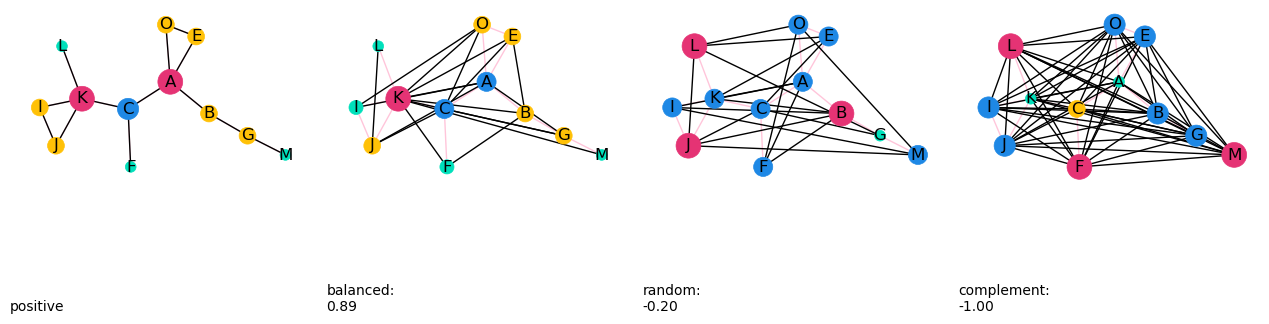

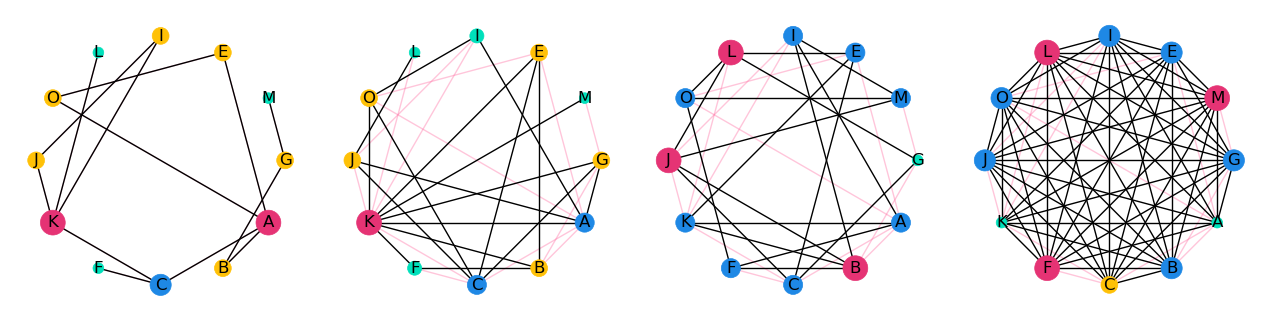

In [16]:
%matplotlib inline
_ = draw_toy_ppis(ppis, ppi_dict)

#### with homodimers

In [30]:
# added F-F
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK\nF\tF'''
ppis = ppis_from_string(raw)

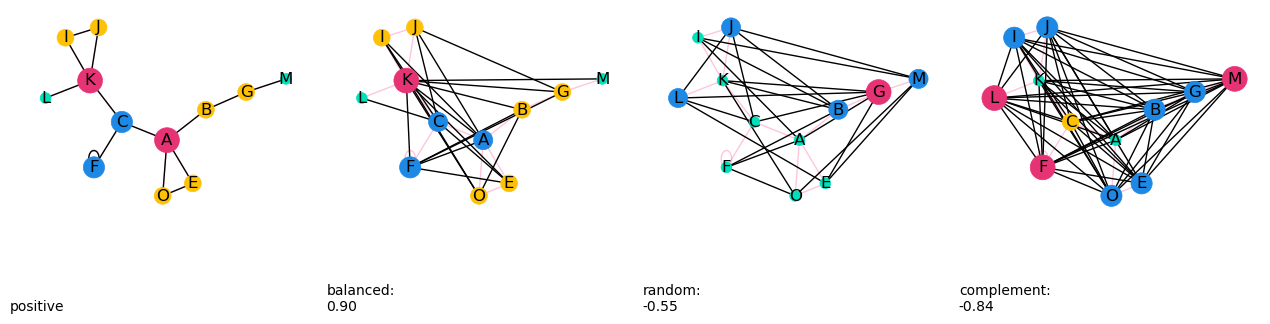

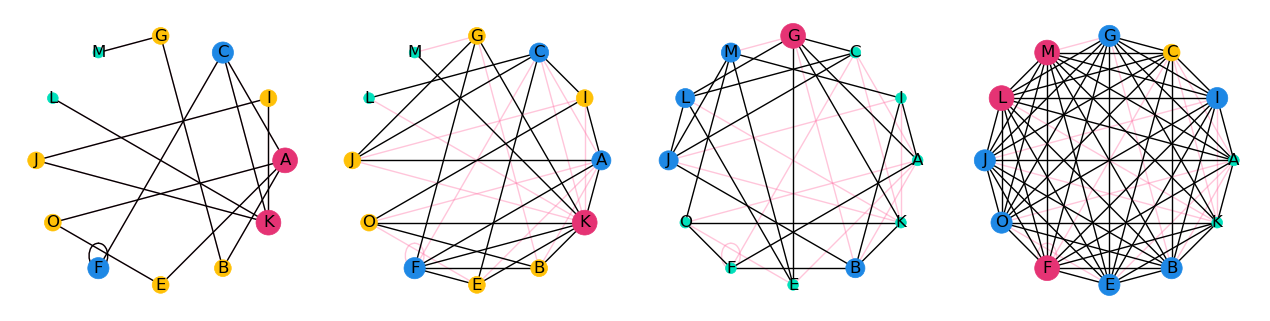

In [32]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.BALANCED), plot=False)
ppi_dict['random'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.RANDOM), plot=False)
ppi_dict['complement'], *_ = find_negative_pairs(
    ppis, Config(ratio=10, seed=42, strategy=SamplingStrategy.BALANCED), plot=False)
# _ = draw_toy_ppis(ppis, ppi_dict)

#### input homodimers, but not allowed as negatives

In [34]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42,
                 strategy=SamplingStrategy.BALANCED,
                 accept_homodimers=False), plot=False)
ppi_dict['random'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42,
                 strategy=SamplingStrategy.RANDOM,
                 accept_homodimers=False), plot=False)
ppi_dict['complement'], *_ = find_negative_pairs(
    ppis, Config(ratio=10, seed=42,
                 strategy=SamplingStrategy.BALANCED,
                 accept_homodimers=False), plot=False)
# _ = draw_toy_ppis(ppis, ppi_dict)

## Train set: APID
#### extract from `<taxid>*_Q1.txt` files

In [35]:
c.qp = unzip_apid(zip_path='apid.zip', keep_human=c.keep_human,
                  keep_interspecies=c.keep_interspecies)
c.qp

PosixPath('apid_q1')

In [36]:
uniprot_ids = extract_apid_uniprot_ids(c.qp)
len(uniprot_ids)

45026

In [37]:
ppis = extract_apid_ppis(c.qp)
len(ppis)

161598

#### select small subset

In [25]:
if c.train_species:
    ppis = ppis.loc[ppis.species.isin(c.train_species | c.val_species)]
    uniprot_ids = set(np.unique(ppis.iloc[:, [0, 1]]))
len(ppis), len(uniprot_ids)

(161598, 45026)

#### interactions in multiple interactomes
Check if there are PPIs (based on UniProt IDs) that occur in several species. We use APID `noISI` data per default, so the exclusion of this data is not implemented.

In [26]:
find_multi_species_ppis(ppis)

,UniprotID_A,UniprotID_B,species


In [27]:
# proof that actually worked: add some dummy data
for i in [0, 1]:
    s = ppis.iloc[i].copy()
s.species = 'marsupilami'
ppis = pd.concat([ppis, pd.DataFrame(s).T], axis=0)

marsu = find_multi_species_ppis(ppis)

# drop the dummy data
ppis = ppis.loc[ppis.species != 'marsupilami']
marsu

,UniprotID_A,UniprotID_B,species
1,P11311,P75330,272634
1,P11311,P75330,marsupilami


or more generally protein IDs that occur in several species:

In [28]:
find_multi_species_proteins(ppis)

,UniprotID,species


#### download sequences

In [30]:
# skip if re-running this w/o changes above or deleting files
_ = uniprot_api_fetch(uniprot_ids, c.ap / 'apid')

jobId: 2a2db46353dacee4c11c601d8b16b1df9d260e6c
apid: query + tab ... 45028:0
apid: fasta ...API FASTA: bcf6f287e082af32e206aa5f8a1225926088299c876b5ecfb33a15ad6cf6bb17


hash FASTA: 44893it [00:12, 3684.53it/s]
fetch isoforms/archive: 100%|██████████████████████████████████| 80/80 [03:33<00:00,  2.66s/it]


#### map IDs to seq hashes

In [32]:
hash_ppis = ppis_to_hashes(ppis, c.ap / 'apid.json').drop_duplicates()
hash_ppis.head()

,hash_A,hash_B,species
12072,CRC-000140D8BB91126A,CRC-67C592366ECCE014,3702
7652,CRC-0004FA7836A741E8,CRC-01BA7B4FE6D56ECE,192222
7966,CRC-0004FA7836A741E8,CRC-739AB6BCED625795,192222
8659,CRC-0004FA7836A741E8,CRC-74F8BFE51572E67B,192222
4420,CRC-0004FA7836A741E8,CRC-F333108A3DE60F78,192222


In [33]:
len(ppis) - len(hash_ppis)

1079

In [34]:
fasta = SeqIO.to_dict(SeqIO.parse(c.ap / 'apid.hash.fasta', 'fasta'))
len(fasta)

44697

#### filter by seq length

In [35]:
c.min_seq_len, c.max_seq_len

(50, 1500)

dropped 9426/160519 PPIs from length filtering
dropped 0/42494 table IDs and 0/151093 rows, and 2203/44697 sequence IDs


(44697, 42494)

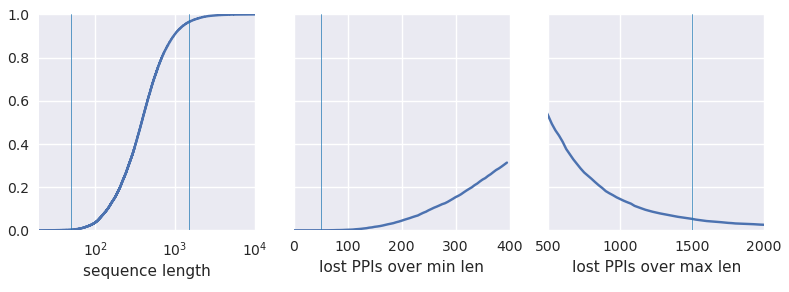

In [36]:
_hash_ppis, _fasta, _ = filter_ppis_and_fasta_by_len(
    hash_ppis, fasta, c.min_seq_len, c.max_seq_len)
len(fasta), len(_fasta)

continue if these limits were ok, or change/set the values for
`cfg.min_seq_len, cfg.max_seq_len` and re-run the filtering cell

In [37]:
hash_ppis = _hash_ppis
fasta = _fasta

#### homodimer share
Overall count, share, overall PPI count

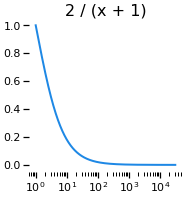

In [38]:
with mpl.rc_context({'figure.dpi': 36}):
    _ = plot_theoretical_homodimer_share()

(False, 4248, 0.0281, 151093)

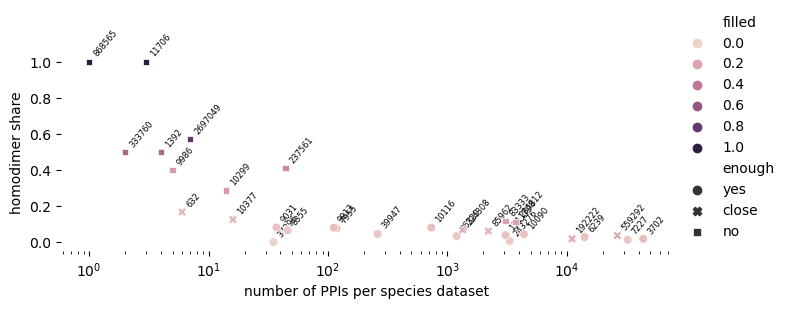

In [39]:
_ = plot_homodimer_share(hash_ppis, c.ratio)
c.accept_homodimers, *count_homodimers(hash_ppis),

In [40]:
if not c.accept_homodimers:
    hash_ppis = drop_homodimers(hash_ppis)
hash_ppis, fasta = shrink_both_ways(hash_ppis, fasta)
len(hash_ppis), len(fasta)

dropped 0/42042 table IDs and 0/146845 rows, and 452/42494 sequence IDs


(146845, 42042)

#### degree distributions
Look at some of those. In the next step, we will try to identify interactions between hubs and proteins that occur only once; and remove those PPIs. This will shrink the set of proteins and the degree of the hub; and we'll need less SwissProt proteins for it.

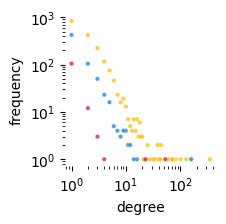

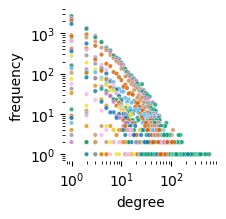

In [41]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degree_distribution(hash_ppis.loc[hash_ppis.species.isin(
        [7955, 10116, 284812])].copy(), 2.4)
    fg._legend.remove()
    # for sfx in ['svg', 'png']:
    #     fg.savefig(f'degree_distrs.{sfx}', dpi=300)

    fg = plot_degree_distribution(hash_ppis)
    fg._legend.remove()

#### remove proteins that only interact with an über-hub?
so that we need less extra proteins. Either directly remove hubs and hope that also drops a lot of proteins that interact only with them; or directly remove proteins that only interact with hubs.

First squint at numbers a bit: At what percentage do overkill-hubs start?

In [42]:
fetch_degrees(hash_ppis).groupby('species')['degree'].describe(percentiles=[.9, .95, .98])

,count,mean,std,min,50%,90%,95%,98%,max
species,,,,,,,,,
632,9.0,1.111111,0.333333,1.0,1.0,1.2,1.60,1.84,2.0
1392,4.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.00,1.0
3702,9041.0,9.466209,23.635829,1.0,3.0,22.0,35.00,60.20,570.0
6239,5100.0,5.358431,11.563062,1.0,2.0,12.0,21.00,38.00,232.0
7227,8520.0,7.468310,12.544413,1.0,3.0,19.0,29.00,45.00,327.0
7955,123.0,1.772358,5.079391,1.0,1.0,2.0,2.00,3.56,53.0
8355,68.0,1.264706,0.682787,1.0,1.0,2.0,2.00,4.00,4.0
9031,54.0,1.259259,0.520710,1.0,1.0,2.0,2.00,2.94,3.0
9913,106.0,1.943396,2.041616,1.0,1.0,5.0,7.00,7.90,12.0


Fetch the node degrees and protein numbers

In [43]:
ppi_dgs = fetch_degrees(hash_ppis, as_dict=True)
p_dgs = fetch_n_proteins(hash_ppis).to_dict()
for ch, num in zip('AB', '01'):
    hash_ppis[f'degree_{num}'] = hash_ppis[f'hash_{ch}'].apply(ppi_dgs.get)

# sort the two columns of degrees
hash_ppis[['degree_0', 'degree_1']] = np.sort(
    hash_ppis[['degree_0', 'degree_1']], axis=1)
hash_ppis['n_seqs'] = hash_ppis.species.apply(p_dgs.get)
hash_ppis.head()

,hash_A,hash_B,species,minlen,maxlen,degree_0,degree_1,n_seqs
12072,CRC-000140D8BB91126A,CRC-67C592366ECCE014,3702,231,329,1,5,9041
7652,CRC-0004FA7836A741E8,CRC-01BA7B4FE6D56ECE,192222,129,312,4,89,1272
7966,CRC-0004FA7836A741E8,CRC-739AB6BCED625795,192222,312,389,4,37,1272
8659,CRC-0004FA7836A741E8,CRC-74F8BFE51572E67B,192222,110,312,4,44,1272
4420,CRC-0004FA7836A741E8,CRC-F333108A3DE60F78,192222,64,312,4,7,1272


In [44]:
# find the pairs
greedy = 2
dppis = hash_ppis.loc[(hash_ppis.degree_0 == 1) & (hash_ppis.degree_1 >= hash_ppis.n_seqs / c.ratio / greedy)].copy()
len(dppis), len(hash_ppis), 'of pairs will drop ...'

(942, 146845, 'of pairs will drop ...')

In [45]:
_hash_ppis = hash_ppis.iloc[~hash_ppis.index.isin(dppis.index)].copy()
_hash_ppis, _fasta = shrink_both_ways(_hash_ppis, fasta.copy())
len(_hash_ppis), len(hash_ppis), len(_fasta), len(fasta)

dropped 0/39452 table IDs and 0/138333 rows, and 2590/42042 sequence IDs


(138333, 146845, 39452, 42042)

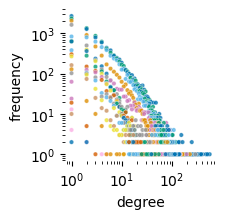

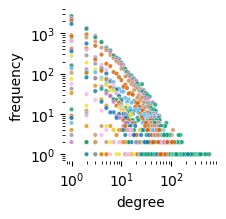

In [46]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degree_distribution(_hash_ppis, 2.4)
    fg._legend.remove()
    # the og one
    fg = plot_degree_distribution(hash_ppis, 2.4)
    fg._legend.remove()

In [47]:
if False:  # of course off by default
    hash_ppis = _hash_ppis
    fasta = _fasta

#### species lookup
Cheating here: the `59251` fell from the sky

In [48]:
taxonomy = fetch_taxonomic_info(pd.concat((
    hash_ppis.species, pd.Series([9606] * 59251))
).rename('species')).sort_values(by='n_ppis')
taxonomy['set_name'] = ''
taxonomy.loc[~taxonomy.species.isin(c.val_species | {9606}), 'set_name'] += '_train'
taxonomy.loc[taxonomy.species.isin(c.val_species), 'set_name'] += '_validate'
taxonomy.loc[taxonomy.species == 9606, 'set_name'] = 'test'
taxonomy.set_name = taxonomy.set_name.str.lstrip('_')
taxonomy.loc[taxonomy.name.str.startswith('Campylob'), 'name'] = 'Campylobacter jejuni'
taxonomy.loc[taxonomy.name.str.startswith('Sever'), 'name'] = 'SARS-CoV 2'
taxonomy

100%|██████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


,species,name,n_ppis,set_name
25,333760,Human papillomavirus type 16,1,train
1,1392,Bacillus anthracis,2,train
28,2697049,SARS-CoV 2,3,train
10,9986,Oryctolagus cuniculus,3,train
0,632,Yersinia pestis,5,train
13,10299,Human alphaherpesvirus 1 strain 17,10,train
14,10377,Human herpesvirus 4 strain B95-8,14,train
22,237561,Candida albicans SC5314,26,validate
7,9031,Gallus gallus,34,validate
16,37296,Human gammaherpesvirus 8,35,validate


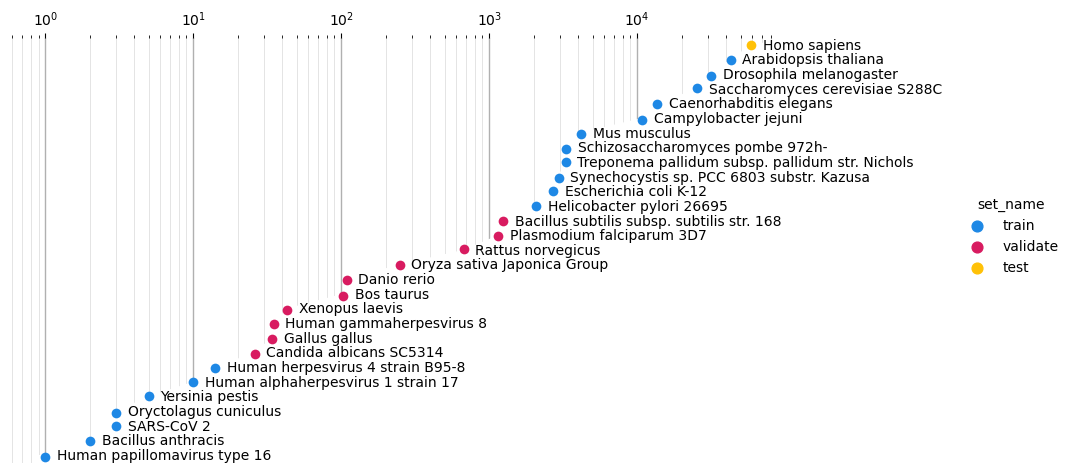

In [49]:
_ = plot_interactome_sizes(taxonomy)

#### download proteomes

In [76]:
# skip if re-running this w/o changes above or deleting files
if c.add_proteomes:
    fetch_proteomes(set(taxonomy.species) | {9606}, c.pp)

100%|███████████████████████████████| 29/29 [03:19<00:00,  6.86s/it, batch=Human herpesvirus 8]


## Validation set: APID
#### val: select species/proteins
Either by sampling a subset of proteins and selecting the PPIs or picking the ones for one or more particular species

In [77]:
c.val_set_size, c.val_species

(0.1, {7955, 8355, 9031, 9913, 10116, 36329, 37296, 39947, 224308, 237561})

In [78]:
taxonomy.loc[taxonomy.species.isin(c.val_species)]

,species,name,n_ppis,set_name
22,237561,Candida albicans SC5314,26,validate
7,9031,Gallus gallus,34,validate
16,37296,Human gammaherpesvirus 8,35,validate
6,8355,Xenopus laevis,43,validate
9,9913,Bos taurus,103,validate
5,7955,Danio rerio,109,validate
17,39947,Oryza sativa Japonica Group,248,validate
12,10116,Rattus norvegicus,673,validate
15,36329,Plasmodium falciparum 3D7,1156,validate
21,224308,Bacillus subtilis subsp. subtilis str. 168,1247,validate


In [79]:
hash_ppis['label'] = 1
if c.val_species is not None:
    train, val = make_validation_species(hash_ppis, c.val_species)
else:
    # if the set becomes too large, try another seed!
    # With this approach, PPIs *will* be lost
    train, val = make_validation_split(hash_ppis, c.val_set_size, c.seed)
c.val_species = set(val.species)
c.train_species = set(train.species)
len(train), len(train) / len(hash_ppis), len(val), len(val) / len(hash_ppis)

(143171, 0.9749804215329089, 3566, 0.02428410909462358)

In [80]:
val.head()

,hash_A,hash_B,species,minlen,maxlen,degree_0,degree_1,n_seqs,label
122,CRC-000BC5DD420D0669,CRC-2808F51BBD3A8B6E,7955,264,363,1,1,123,1
184,CRC-0011BA5214873CAF,CRC-303501D8DA2E2440,39947,133,282,1,3,252,1
513,CRC-0014B58B77D0127B,CRC-915DCA04EF0B2902,10116,573,752,1,159,643,1
1139,CRC-0038A2491FC5A50F,CRC-62AD6CA7294E1FAA,224308,218,334,2,218,603,1
942,CRC-0038A2491FC5A50F,CRC-7C00301A62188306,224308,196,218,2,19,603,1


In [81]:
val.species.unique(), train.species.unique()

(array([  7955,  39947,  10116, 224308,  36329,   9913, 237561,   8355,
         37296,   9031]),
 array([   3702,  192222, 1111708,   10090,    7227,  559292,    6239,
         284812,   83333,  243276,   85962,   10377,   10299,    9986,
           1392,  333760, 2697049,     632]))

Separate the validation set sequences from the ones remaining as train set

#### train: save seqs + positives


In [82]:
_, train_seqs = shrink_both_ways(train.copy(), fasta.copy())
c.train_seqs = len(train_seqs)
len(train_seqs), len(fasta)

dropped 0/39393 table IDs and 0/143171 rows, and 2649/42042 sequence IDs


(39393, 42042)

In [83]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_raw_fasta, 'fasta')
train.to_csv(c.train_raw_tsv, sep='\t', header=True, index=False)
c.train_raw_fasta, c.train_raw_tsv

(PosixPath('apid/apid_train_raw.fasta'), PosixPath('apid/apid_train_raw.tsv'))

#### val: save seqs + positives

In [84]:
_, val_seqs = shrink_both_ways(val.copy(), fasta.copy())
len(val_seqs), len(fasta)

dropped 0/2626 table IDs and 0/3566 rows, and 39416/42042 sequence IDs


(2626, 42042)

In [85]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_raw_fasta, 'fasta')
val.to_csv(c.val_raw_tsv, sep='\t', header=True, index=False)
c.val_raw_fasta, c.val_raw_tsv

(PosixPath('apid/apid_validation_raw.fasta'),
 PosixPath('apid/apid_validation_raw.tsv'))

Mind that the TSVs will contain only positives! Sample negatives only after most of the `uniqueprot`-shebang.

## Test set: HuRI
#### download and extract PPIs

In [86]:
c.psi_path

PosixPath('hi_union.psi')

In [87]:
# it's somehow a lot faster to download this from a browser!
# or run !wget "http://www.interactome-atlas.org/data/HI-union.psi" -O "hi_union.psi"
download_y2h_interactome(c.psi_path)

already downloaded and SHA256 checks out


PosixPath('hi_union.psi')

In [88]:
huri_ppis, huri_seq_ids = extract_huri_ppis(c.psi_path)
len(huri_ppis)

97888

#### pick a subset?

In [89]:
frac = 6
huri_ids = np.unique(huri_ppis.iloc[:, [0, 1]])
len(train), len(val), len(val_seqs) + len(train_seqs) + len(huri_ids) // frac

(143171, 3566, 43592)

In [90]:
rng = np.random.default_rng(12345)
chc = set(rng.choice(huri_ids, size=len(huri_ids) // frac))
len(chc), list(chc)[:10]

(1429,
 ['Q6P1M0-2',
  'A8KAH6',
  'Q9Y6Q5-2',
  'Q12864',
  'Q4G176',
  'Q8NHS1',
  'Q9H1Z8',
  'P54725-1',
  'Q08043',
  'Q9UJA3-4'])

In [91]:
_huri_ppis = huri_ppis.loc[(huri_ppis[0].isin(chc)) & (huri_ppis[1].isin(chc))]
_huri_ppis

,0,1,species
65,Q7Z7H3,Q7Z7H3,9606
66,Q9BVN2-2,I3L0H3,9606
183,Q86W74-2,Q5JX71,9606
268,Q8NFF5-2,Q9UNS2-1,9606
273,Q96LM6,Q99895,9606
...,...,...,...
234347,Q3LI66,Q6UY14-1,9606
236178,P17568,Q9BWG6-1,9606
236524,O95870-1,Q9BVK8-1,9606
236747,Q9BZW7-1,Q9P2K3-2,9606


In [92]:
if False:  # off by default
    huri_ppis = _huri_ppis
    for k in huri_seq_ids.keys():  # this is not wrong
        huri_seq_ids[k] = {v for v in huri_seq_ids[k] if v in chc}

##### now back to normal

In [93]:
huri_seqs, _ = fetch_huri_seqs(huri_seq_ids, c.hp / 'huri')
len(huri_seqs)

loading from huri/huri.hash.fasta and huri/huri.json


9119

#### map + filter PPIs

In [94]:
print(set(huri_ppis.species))  # only human, but keep the label
huri_ppis.head()

{9606}


,0,1,species
0,P0DP25,A0A087WXN0,9606
1,Q68D86-1,Q9HD26-2,9606
2,Q13515,Q9UJW9,9606
3,P30049,Q05519-2,9606
4,ENSP00000462298,P43220,9606


In [95]:
# some 35K protein IDs point to the same sequence
huri_hash_ppis = ppis_to_hashes(huri_ppis, c.hp / 'huri.json')
len(huri_ppis), len(huri_ppis) - len(huri_hash_ppis), len(huri_hash_ppis)

(97888, 35329, 62559)

In [96]:
huri_hash_ppis.head()

,hash_A,hash_B,species
22905,CRC-000037AE195F7A9D,CRC-82152E496B924EEC,9606
143452,CRC-000624825E507385,CRC-C116E348E8B7AD2B,9606
62304,CRC-000624825E507385,CRC-D7C7F6F2CD922775,9606
7538,CRC-000CFE2B83394B42,CRC-40C7C3686632F6A7,9606
27848,CRC-0012F055C7F2A233,CRC-2E96FD0179EE119D,9606


In [97]:
# make sure we don't test on sequences that we trained on;
# A LOT more checks later
huri_hash_ppis = remove_ids_from(
    huri_hash_ppis, black_list_fasta=c.train_raw_fasta)
len(huri_hash_ppis)

61208

In [98]:
*count_homodimers(huri_hash_ppis), c.accept_homodimers

(752, 0.0123, 61208, False)

In [99]:
if not c.accept_homodimers:
    huri_hash_ppis = drop_homodimers(huri_hash_ppis)
huri_hash_ppis, huri_seqs = shrink_both_ways(huri_hash_ppis, huri_seqs)
len(huri_hash_ppis), len(huri_seqs)

dropped 0/8953 table IDs and 0/60456 rows, and 166/9119 sequence IDs


(60456, 8953)

dropped 1205/60456 PPIs from length filtering
dropped 0/8773 table IDs and 0/59251 rows, and 180/8953 sequence IDs


(8953, 8773)

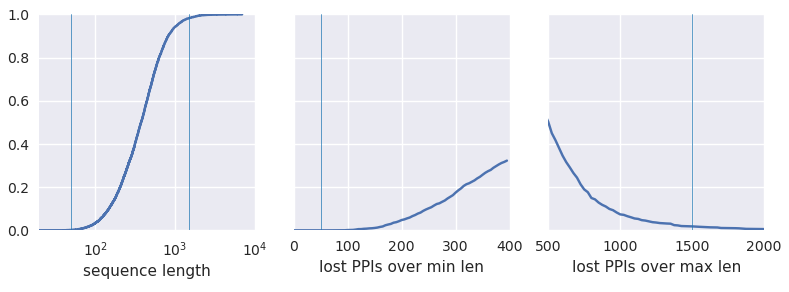

In [100]:
_huri_hash_ppis, _huri_seqs, fig = filter_ppis_and_fasta_by_len(
    huri_hash_ppis, huri_seqs, c.min_seq_len, c.max_seq_len)
len(huri_seqs), len(_huri_seqs)

#### test: save seqs + positives

In [101]:
huri_hash_ppis = _huri_hash_ppis
huri_seqs = _huri_seqs

In [102]:
_ = SeqIO.write(huri_seqs.values(), c.test_raw_fasta, 'fasta')
huri_hash_ppis.to_csv(c.test_raw_tsv, sep='\t', header=True, index=False)
c.test_raw_fasta, c.test_raw_tsv

(PosixPath('huri/huri_test_raw.fasta'), PosixPath('huri/huri_test_raw.tsv'))

## Test + validation: redundancy-reduce

Use [rostclust](https://git.rostlab.org/bernhoferm/mmseqs2-uniqueprot/-/tree/F_typer_app) to create non-redundant `test` and `validation` sets. <br> Don't run the next cells in the wrong order, and don't forget to copy the files back and forth if you are running `rostclust` elsewhere! <br>In particular, copy files after `shrink_files_both_ways`.

In [103]:
c.hval_config

{'shortAlignmentLen': 50,
 'longSeqLen': 180,
 'reduceRandomAlign': False,
 'clusterThreshold': 20}

In [104]:
with c.hval_config_path.open('w') as json_file:
    json_file.write(json.dumps(hval_config, indent=4))

The flag below allows me to test this notebook without the MMseqs2 runs. Leave `rostclust` at `False` and copy the two result files to this folder; or run `rostclust uniqueprot[2D]` from this system.

Haven't transferred these two runs to SLURM yet, sorry!

In [105]:
c.rostclust

'/home/k/kaindll/mambaforge/envs/ppi/bin/rostclust'

In [106]:
# redundancy-reduce the validation set
run_uniqueprot(c.val_raw_fasta, c.val_rr_fasta,
               c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json apid/apid_validation_raw.fasta apid/apid_validation_rr.fasta
using temporary directory apid/apid_validation_rawlfrfwged
extract hvals from alignments: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]
 2044/2626 non-redundant in apid/apid_validation_raw.fasta written to apid/apid_validation_rr.fasta


In [107]:
# cluster the test set against val
run_uniqueprot2D(c.test_raw_fasta, c.val_rr_fasta,
                 c.test_nr_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json huri/huri_test_raw.fasta apid/apid_validation_rr.fasta huri/huri_test_nr.fasta
using temporary directory huri/huri_test_rawl5n5owx5
extract hvals from alignments: 100%|██████████| 4/4 [00:00<00:00, 10.57it/s]
 7395/8773::2044 non-redundant in huri/huri_test_raw.fasta against apid/apid_validation_rr.fasta written to huri/huri_test_nr.fasta


In [108]:
# redundancy-reduce the test set
run_uniqueprot(c.test_nr_fasta, c.test_rr_fasta,
               c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json huri/huri_test_nr.fasta huri/huri_test_rr.fasta
using temporary directory huri/huri_test_nr08dcziai
extract hvals from alignments: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]
 5370/7395 non-redundant in huri/huri_test_nr.fasta written to huri/huri_test_rr.fasta


In [109]:
fastalen = lambda _file: len([r.id for r in SeqIO.parse(_file, 'fasta')])

In [110]:
# also drop PPIs accordingly
assert c.test_rr_fasta.is_file()
shrink_files_both_ways(c.test_raw_tsv, c.test_rr_fasta,
                       new_tsv_name=c.test_rr_tsv)
c.test_seqs = fastalen(c.test_rr_fasta)
assert c.val_rr_fasta.is_file()
shrink_files_both_ways(c.val_raw_tsv, c.val_rr_fasta,
                       new_tsv_name=c.val_rr_tsv)
c.val_seqs = fastalen(c.val_rr_fasta)

dropped 3403/8773 table IDs and 40145/59251 rows, and 912/5370 sequence IDs
dropped 582/2626 table IDs and 1287/3566 rows, and 294/2044 sequence IDs


## Prepare proteomes
#### filter by len and id

In [111]:
if c.add_proteomes:
    filter_proteomes(c.pp, c.min_seq_len, c.max_seq_len,
                     None if (hasattr(c, 'legacy') and c.legacy)
                     else c.train_raw_fasta)
# do not skip this!

100%|██████████████████████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


#### run separately: faster
Separately clustering the proteomes against the test/validation set and then redundancy-reducing each one is faster and might lead to a more balanced combined proteome set that is better fit to sample from than merging all proteomes first and then running the two steps on huge files.

If available, run this on a SLURM cluster:

In [112]:
c.slurm, c.slurm_node_limit

(True, 15)

In [117]:
if c.slurm:
    import snakemake

    snakemake.snakemake(snakefile='Snakefile',
                        config=c.to_dict(),
                        nodes=c.slurm_node_limit,
                        cluster=f'sbatch -p All -N 1')

Building DAG of jobs...
Using shell: /bin/bash
Provided cluster nodes: 15
Job stats:
job                     count    min threads    max threads
--------------------  -------  -------------  -------------
all                         1              1              1
cluster_against_test       13              1              1
cluster_against_val         4              1              1
red_reduce                  9              1              1
request                     1              1              1
total                      28              1              1

Select jobs to execute...

[Sun Oct 30 22:41:41 2022]
rule cluster_against_test:
    input: swissprot/284812_nr_val.fasta
    output: swissprot/284812_nr_valtest.fasta
    jobid: 36
    reason: Missing output files: swissprot/284812_nr_valtest.fasta
    wildcards: species=284812
    resources: mem_mb=1000, disk_mb=1000, tmpdir=/tmp/user/31049

Submitted job 36 with external jobid 'Submitted batch job 401259'.

[Sun Oct 30 22:41:41

#### train: cluster against val
Mind that `train_species` and `val_species` may overlap! We deal with that later.

In [118]:
s = None
if not c.slurm:
    s = rr_pattern_proteomes(
        c.train_species, c.pp, '{sp}.fasta', 'val',
        c.val_rr_fasta, c.hval_config_path, not c.rostclust)
s

#### train: cluster against test

In [119]:
if not c.slurm:
    s = rr_pattern_proteomes(
        c.train_species, c.pp, '{sp}_nr_val.fasta', 'valtest',
        c.test_rr_fasta, c.hval_config_path, not c.rostclust)
s

These `_nr_valtest.fasta` proteomes are now ready to be used as negatives for the train set!

#### val: cluster against val

In [120]:
if not c.slurm:
    # this is the same as the first call, just for different files!
    s = rr_pattern_proteomes(
        c.val_species, c.pp, '{sp}.fasta', 'val',
        c.val_rr_fasta, c.hval_config_path, not c.rostclust)
s

#### val: redundancy-reduce

In [121]:
if not c.slurm:
    # now a 1D run -> no database/reference FASTA
    s = rr_pattern_proteomes(
        c.val_species, c.pp, '{sp}_nr_val.fasta', 'val',
        None, c.hval_config_path, not c.rostclust)
s

#### val: merge

In [122]:
val_concat = c.pp / 'val_proteome_concat.fasta'
val_concat_rr = val_concat.with_stem(val_concat.stem + '_rr')

In [123]:
merge_pattern_proteomes(c.val_species, val_concat, c.pp, '{sp}_rr_val.fasta')

#### val: redundancy-reduce merged set

In [124]:
run_uniqueprot(val_concat, val_concat_rr, c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json swissprot/val_proteome_concat.fasta swissprot/val_proteome_concat_rr.fasta
using temporary directory swissprot/val_proteome_concatf9wo9gzw
extract hvals from alignments: 100%|██████████| 34/34 [01:06<00:00,  1.94s/it]
 47009/83306 non-redundant in swissprot/val_proteome_concat.fasta written to swissprot/val_proteome_concat_rr.fasta


#### test: cluster against val

In [125]:
s = None
if not c.slurm:
    s = run_uniqueprot2D(c.pp / '9606.fasta',
                         c.val_rr_fasta,
                         c.pp / '9606_nr_val.fasta',
                         c.hval_config_path, not c.rostclust)
s

#### test: cluster against test

In [126]:
if not c.slurm:
    s = run_uniqueprot2D(c.pp / '9606_nr_val.fasta',
                         c.test_rr_fasta,
                         c.pp / '9606_nr_valtest.fasta',
                         c.hval_config_path, not c.rostclust)
s

#### test: redundancy-reduce

In [127]:
if not c.slurm:
    s = run_uniqueprot(c.pp / '9606_nr_valtest.fasta', c.pp / '9606_rr_valtest.fasta',
                       c.hval_config_path, not c.rostclust)
s

The `swissprot/9606_rr_valtest.fasta` is not ready to be used yet! Once we know which sequences were actually sampled from `val_proteome_concat_rr.fasta`, we have to cluster the test proteome against that again!

#### collate train/val/test proteomes
Create per-species dicts of potential negative interaction partners.

In [128]:
train_proteome = write_json(read_hash_proteomes(
    c.train_species, c.pp, '{sp}_nr_valtest.fasta'), c.train_proteome)

100%|████████████████████████████████████████████| 18/18 [00:27<00:00,  1.50s/it, batch=2.7e+6]


In [129]:
val_proteome = write_json(parse_val_proteome(val_concat_rr), c.val_proteome)

47009it [00:07, 6597.04it/s] 


In [75]:
# test_proteome = write_json(read_hash_proteomes(
#     {9606}, c.pp, '{sp}_rr_valtest.fasta'), c.test_proteome)

## Generate negatives: examples
Negatives are sampled *per species*. Mind that the test set is human-only!
Start with the train set!
Re-write with proteomes, but without C123 labels.

In [130]:
c.strategy, c.ratio, c.seed, c.accept_homodimers

(<SamplingStrategy.BALANCED: 1>, 10.0, 42, False)

In [131]:
train_proteome = read_json(c.train_proteome)

In [132]:
train.head()

,hash_A,hash_B,species,minlen,maxlen,degree_0,degree_1,n_seqs,label
12072,CRC-000140D8BB91126A,CRC-67C592366ECCE014,3702,231,329,1,5,9041,1
7652,CRC-0004FA7836A741E8,CRC-01BA7B4FE6D56ECE,192222,129,312,4,89,1272,1
7966,CRC-0004FA7836A741E8,CRC-739AB6BCED625795,192222,312,389,4,37,1272,1
8659,CRC-0004FA7836A741E8,CRC-74F8BFE51572E67B,192222,110,312,4,44,1272,1
4420,CRC-0004FA7836A741E8,CRC-F333108A3DE60F78,192222,64,312,4,7,1272,1


In [133]:
train.species.value_counts().rename('n_ppis')

3702       42792
7227       31815
559292     25498
6239       13664
192222     10863
10090       4186
284812      3302
243276      3294
1111708     2944
83333       2707
85962       2068
10377         14
10299         10
632            5
9986           3
2697049        3
1392           2
333760         1
Name: n_ppis, dtype: int64

#### tiny examples

In this symmectric adjacency matrix, true PPIs and interactions that are not allowed as negatives are shown in blue. This often includes the diagonal; homodimers. Selected negatives are in red. The last row/column indicates *wanted* interactions that could not be satisfied in the existing set; with darker/lighter red indicating more than one extra interaction for the protein in that row/column. These extra negative interaction partners were drawn from SwissProt proteomes.

#### small example

#### multi-species example

#### tests from APID train

In this example, the number of available negatives falls far short of the target. The adjacency matrix is completely filled; and each protein would *should* get more than one extra negative interaction partner. However, we see that only 7 proteins in the non-redundant SwissProt proteome for this species were not already in the given set of PPIs, and we would actually need 30 to generate negatives at the target ratio.

## APID train
#### generate negatives

In [134]:
# sanity check if there are any proteins in test that
# were already in train. re: "do not add back in identical ones"
assert not ({r.id for r in SeqIO.parse(c.train_raw_fasta, 'fasta')} & {
    r.id for r in SeqIO.parse(c.test_rr_fasta, 'fasta')})

In [135]:
train = pd.read_csv(c.train_raw_tsv, sep='\t', header=0)
train_seqs = SeqIO.to_dict(SeqIO.parse(c.train_raw_fasta, 'fasta'))
len(train), len(train_seqs)

(143171, 39393)

In [224]:
train_ppis, train_negs, train_bias, _ = make_negatives(train, c, train_proteome)

sampling negatives per species! aim for 1431710


632:   0%|                                                             | 0/100 [00:00<?, ?it/s]

632: 138it [00:00, 12925.44it/s]                                                               


632 extras hash: 71ECBAABF7451750


1392: 72it [00:00, 11449.42it/s]                                                               


1392 extras hash: 4F2E19951056976B

9986: 96it [00:00, 10464.50it/s]                                                               


9986 extras hash: 5F9212E6CFCB6C98


10299: 234it [00:00, 8906.64it/s]                                                              
10377: 406it [00:00, 8890.32it/s]                                                              
243276:   0%|                                                        | 0/65880 [00:00<?, ?it/s]

10299 extras hash: 6E50BFEE3A42F112


83333:   0%|                                                         | 0/54140 [00:00<?, ?it/s]

10377 extras hash: F7EF752E69BD3CFE


333760: 40it [00:00, 1798.93it/s]                                                              
2697049: 114it [00:00, 4392.02it/s]                                                            


333760: 0/10 interactome negatives
333760 extras hash: 5325C055F0006A55


1111708:   0%|                                                       | 0/58880 [00:00<?, ?it/s]

2697049 extras hash: 4084D7E9F3EED2D6


85962: 41546it [00:09, 4190.77it/s]                                                            
3702:   1%|▍                                            | 7754/855840 [00:09<17:41, 798.74it/s]

85962 extras hash: 2F2E77C06D65A222


243276: 82330it [00:16, 4875.84it/s]██████▊            | 46972/66040 [00:16<00:06, 2982.54it/s]
7227:   2%|▉                                           | 14144/636300 [00:16<10:54, 950.32it/s]

243276 extras hash: F4CA6EC9884B133B


83333: 54168it [00:17, 3125.99it/s]                                                            
284812:  74%|██████████████████████████████▉           | 48596/66040 [00:17<00:05, 3309.85it/s]

83333 extras hash: 8C4E644D22FDDF4F


1111708: 58882it [00:20, 2921.25it/s]                                                          
3702:   2%|▊                                           | 16682/855840 [00:20<14:02, 996.00it/s]

1111708 extras hash: 59793843A8DF1D25


284812: 69498it [00:23, 2951.58it/s]█▏                 | 48924/83720 [00:23<00:15, 2288.68it/s]
192222:  41%|████████████████▌                        | 88032/217260 [00:23<00:32, 4008.51it/s]

284812 extras hash: D51C13EF6E3EA12D


10090: 84454it [00:38, 2193.31it/s]                   | 35938/636300 [00:38<09:53, 1011.92it/s]
7227:   6%|██▍                                         | 36040/636300 [00:38<10:15, 974.93it/s]

10090 extras hash: 34F29D3F3795302A


192222: 241908it [00:56, 4300.63it/s]                 | 84802/509960 [00:56<05:15, 1349.67it/s]
559292:  17%|██████▊                                  | 84950/509960 [00:56<05:07, 1383.52it/s]

192222 extras hash: 4AAA7582B2FE4E15


6239: 274736it [02:34, 1774.25it/s]                  | 165576/855840 [02:34<09:38, 1193.75it/s]
559292:  52%|████████████████████▋                   | 263306/509960 [02:34<02:06, 1950.23it/s]

6239 extras hash: 35D86A692FF4B754


559292: 512968it [04:43, 1806.29it/s]                | 322720/855840 [04:44<07:02, 1260.42it/s]
3702:  38%|███████████████▊                          | 323106/855840 [04:44<06:59, 1270.07it/s]

559292 extras hash: 3311F8A6CB2E2E15


7227: 636362it [08:28, 1252.54it/s]                                                            
3702:  71%|█████████████████████████████▋            | 605508/855840 [08:28<03:10, 1312.89it/s]

7227 extras hash: 37597A36EEC27ACC


3702: 866340it [11:46, 1226.85it/s]                                                            


3702 extras hash: 591FA00D88DBDE39
1448733 negatives with overall 0.994 and average per-species bias of 0.971±0.082 (std)


1449121 negatives with overall 0.994 and average per-species bias of 0.971±0.082 (std)

#### bias

In [225]:
c.train_bias = train_bias.set_index('species').to_dict()['bias']
train_bias.sort_values(by='bias')

,species,bias
17,2697049,0.65
12,243276,0.892632
0,632,0.977859
11,192222,0.98389
7,10299,0.992454
8,10377,0.99264
15,559292,0.996362
10,85962,0.999901
2,3702,0.999901
3,6239,0.99992


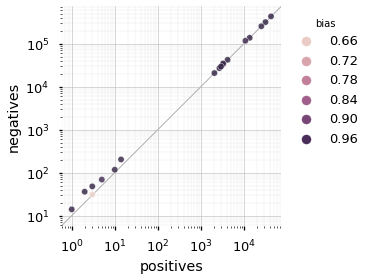

In [226]:
with mpl.rc_context({'figure.dpi': 72}):
    _ = plot_bias(train_ppis, train_negs, train_bias, c.ratio)
fig.savefig('train_bias.svg')

#### degrees
Evaluate how close the real ratio of negative : positive interactions per protein is to our target ratio

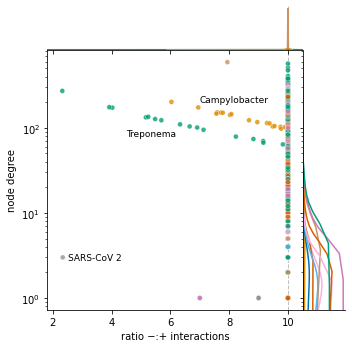

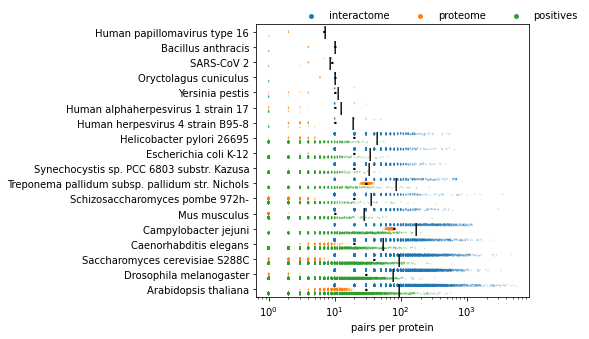

In [277]:
with mpl.rc_context({'figure.dpi': 72}):
    fig, fig2, tdf, tnsp = plot_ratio_degree(
        train_ppis, train_negs, c.ratio, taxonomy)
ax = fig.axes[0]
ax.set(xlim=(1.8, 10.5))
ax.annotate('SARS-CoV 2', xy=(2.5, 2.8), size=9)  # 2697049
ax.annotate('Treponema', xy=(4.5, 80), size=9)  # 243276
ax.annotate('Campylobacter', xy=(7, 200), size=9)  # 192222
fig.savefig(f'train_ratio_degree.svg')
if fig2 is not None:
    fig2.savefig(f'train_negative_degree.svg')

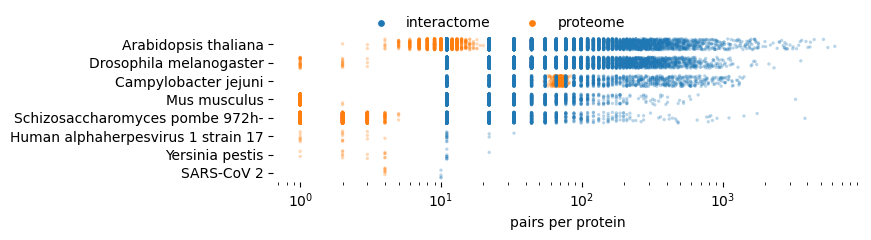

In [228]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degrees_wide(train_ppis, train_negs, taxonomy, False,
                           [3702, 7227, 284812, 10090, 192222, 10299, 632, 2697049])
fg.savefig('train_degree_wide.svg')

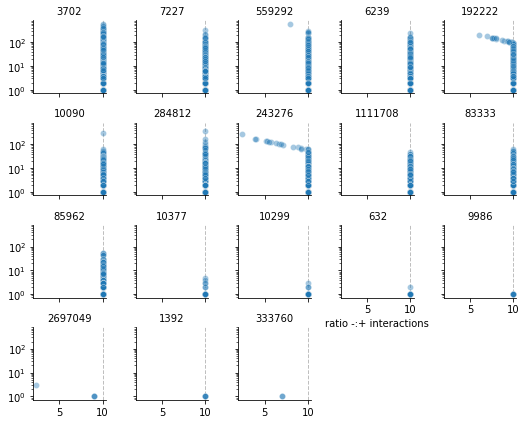

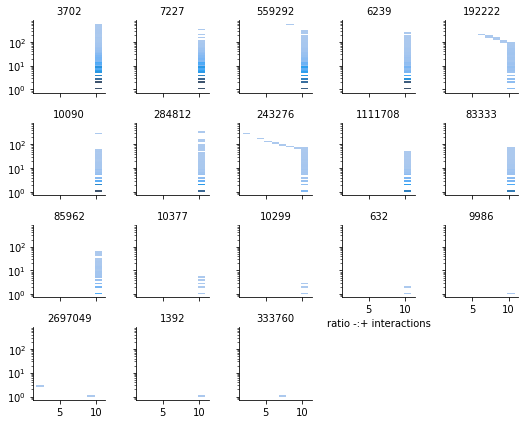

In [229]:
order = (taxonomy.loc[taxonomy.species.isin(train.species)]
             .sort_values(by='n_ppis')['species'][::-1])
with mpl.rc_context({'figure.dpi': 72}):
    g, h = plot_ratio_grids(tdf, order, c.ratio)

In [230]:
desc = (tdf  #.loc[df.degree <= 3]
        .groupby('species')
        .describe()
        ['ratio']
        .sort_values(by='count')
        .round(2)
        .convert_dtypes()
        )
desc

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
333760,2,7.0,0.0,7.0,7.0,7,7,7
2697049,4,7.33,3.33,2.33,7.33,9,9,9
1392,4,10.0,0.0,10.0,10.0,10,10,10
9986,6,10.0,0.0,10.0,10.0,10,10,10
632,9,10.0,0.0,10.0,10.0,10,10,10
10377,15,10.0,0.0,10.0,10.0,10,10,10
10299,16,10.0,0.0,10.0,10.0,10,10,10
243276,684,9.92,0.62,2.32,10.0,10,10,10
85962,939,10.0,0.0,10.0,10.0,10,10,10


#### save
The PPIs are easy:

In [231]:
train_all = pd.concat((train_ppis, train_negs))
train_all.to_csv(c.train_tsv, sep='\t', header=True, index=False)
c.train_size = len(train_all)
c.train_size, c.train_tsv

(1591904, PosixPath('apid_train.tsv'))

But update the set of sequences with the added SwissProt proteins.

In [232]:
assert not set(np.unique(train_ppis.iloc[:, [0, 1]])) - train_seqs.keys()

In [233]:
train_extra = get_proteome_seqs(train_proteome, train_seqs, train_negs)
_ = SeqIO.write(values_sorted_by_key(train_extra),
                c.pp / 'train_extra.fasta', 'fasta')
train_seqs.update(train_extra)
c.train_extra = len(train_extra)
c.train_extra

5392

In [234]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_fasta, 'fasta')
len(train_seqs), c.train_fasta

(44785, PosixPath('apid_train.fasta'))

In [235]:
assert len(train_all), len(train_seqs) == shrink_both_ways(
    train_all.copy(), train_seqs.copy())

## APID validation
#### generate negatives
The `val` DataFrame is not up-to-date, use the contents of `val_rr_tsv` and `val_rr_fasta` instead!

In [236]:
val = pd.read_csv(c.val_rr_tsv, sep='\t', header=0)
val_seqs = SeqIO.to_dict(SeqIO.parse(c.val_rr_fasta, 'fasta'))
len(val), len(val_seqs)

(2279, 1750)

In [237]:
set(val.species)

{7955, 8355, 9031, 9913, 10116, 36329, 37296, 39947, 224308, 237561}

In [238]:
val_proteome = read_json(c.val_proteome)

In [239]:
with mpl.rc_context({'figure.dpi': 64}):
    val_ppis, val_negs, val_bias, _ = make_negatives(val, c, val_proteome)

sampling negatives per species! aim for 22790


8355: 276it [00:00, 11338.18it/s]                                                              


8355 extras hash: 365812102C3BC44E


9031: 334it [00:00, 10385.02it/s]                                                              


9031 extras hash: 97C296D69F8EF972


7955: 602it [00:00, 10795.36it/s]                                                              
224308:   0%|                                                        | 0/21040 [00:00<?, ?it/s]

7955 extras hash: FE1A465EEA19F95F


237561: 394it [00:00, 9440.69it/s]                                                             
37296: 1166it [00:00, 11194.80it/s]


237561 extras hash: A2615D382B188354
37296 extras hash: 467D8FA4EB901782


9913: 1448it [00:00, 8724.65it/s]                                                              


9913 extras hash: 12F6402A1410A594


39947: 1652it [00:00, 10218.62it/s]                                                            


39947 extras hash: 4F80CFAC57664FF0


10116: 5460it [00:00, 9052.94it/s]                      | 4550/14780 [00:00<00:01, 7841.44it/s]


10116 extras hash: C73CF52D6EF4807E


36329: 14792it [00:01, 7859.21it/s]                                                            
224308:  71%|█████████████████████████████▋            | 14844/21040 [00:01<00:00, 8143.53it/s]

36329 extras hash: 273B6511AAE568AC


224308: 25100it [00:03, 8333.55it/s]                                                           


224308 extras hash: 51B8664806DB4B31
25542 negatives with overall 0.999 and average per-species bias of 0.993±0.015 (std)


25552 negatives with overall 0.999 and average per-species bias of 0.993±0.015 (std)

#### bias

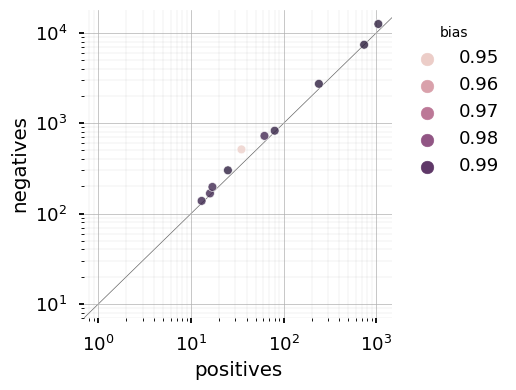

In [240]:
if type(val_bias) == np.float64:
    c.val_bias = val_bias
else:
    assert type(val_bias) == pd.DataFrame
    c.val_bias = val_bias.set_index('species').to_dict()['bias']

    with mpl.rc_context({'figure.dpi': 100}):
        fig = plot_bias(val_ppis, val_negs, val_bias, c.ratio)
    fig.savefig('val_bias.svg')

#### degrees

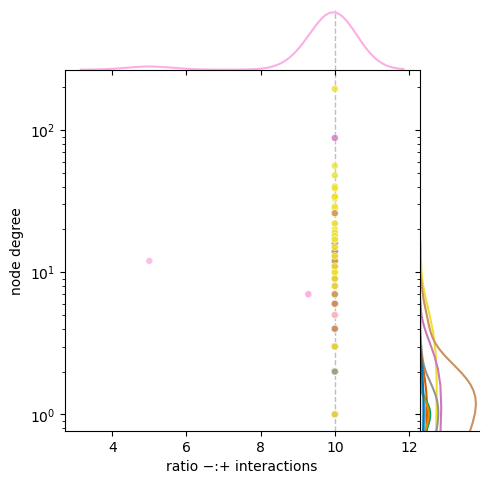

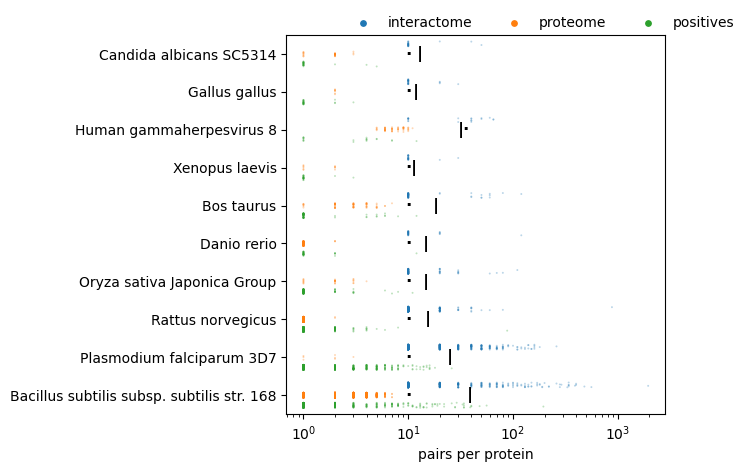

In [278]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, fig2, vdf, vnsp = plot_ratio_degree(
        val_ppis, val_negs, c.ratio, taxonomy)
fig.savefig('val_ratio_degree.svg')
if fig2 is not None:
    fig2.savefig(f'val_negative_degree.svg')

Are we running out of extra proteins again?

In [242]:
vdf.loc[vdf.ratio != c.ratio]

,crc_hash,degree,ratio,species
513,CRC-468877D25B4B0173,7,9.285714,37296
1372,CRC-C34E41D6B181DAFB,7,9.285714,37296
1714,CRC-F8F5876EFDA2BB35,12,5.000000,37296


37296: 35 positives, aim for 350 negatives


37296: 1166it [00:00, 13388.70it/s]                                                            

37296: 117/350 interactome negatives
37296: need 113 extra proteins for 12 hubs; select 53 from 53 additional proteins. Try to create 466 interactions, ideally 38.5 per protein.
37296 extras hash: 467D8FA4EB901782
proteome interactions:
   count  mean   std  min  25%  50%  75%   max
0   53.0  7.47  1.64  5.0  6.0  7.0  9.0  11.0
37296: got 513 negatives with bias 0.949


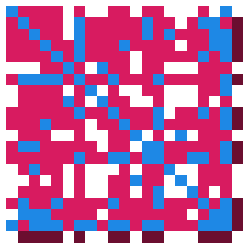

In [243]:
if 37296 in c.val_species:
    with mpl.rc_context({'figure.dpi': 64}):
        v_ppis, v_negs, v_bias, _ = make_negatives(
            val.loc[val.species == 37296].copy(), c, val_proteome)

Yes we are running out of extra (SwissProt) proteins again!

#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [244]:
val_all = pd.concat((val_ppis, val_negs))
val_all.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_size = len(val_all)
c.val_size, c.val_tsv

(27821, PosixPath('apid_validation.tsv'))

In [245]:
assert not set(np.unique(val_ppis.iloc[:, [0, 1]])) - val_seqs.keys()

In [246]:
val_extra = get_proteome_seqs(val_proteome, val_seqs, val_negs)
_ = SeqIO.write(values_sorted_by_key(val_extra),
                c.pp / 'val_extra.fasta', 'fasta')
c.val_extra = len(val_extra)
c.val_extra, len(val_seqs)

(2596, 1750)

In [247]:
val_seqs.update(val_extra)

In [248]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_fasta, 'fasta')
len(val_seqs), c.val_fasta

(4346, PosixPath('apid_validation.fasta'))

In [249]:
assert len(val_all), len(val_seqs) == shrink_both_ways(
    val_all.copy(), val_seqs.copy())

#### cluster against train
Clustering the `APID` validation set against the `APID` train set gives us **C1-3** labels for the validation set.

In [250]:
run_uniqueprot2D(c.val_fasta, c.train_fasta, c.val_c3_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json apid_validation.fasta apid_train.fasta apid/apid_validation_c3.fasta
using temporary directory apid_validationqkkpfepn
extract hvals from alignments: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]
 3176/4346::44785 non-redundant in apid_validation.fasta against apid_train.fasta written to apid/apid_validation_c3.fasta


#### label PPIs

In [251]:
val_pairs = make_c_classes(c.val_tsv, c.val_c3_fasta, c.val_fasta)

#### class sizes

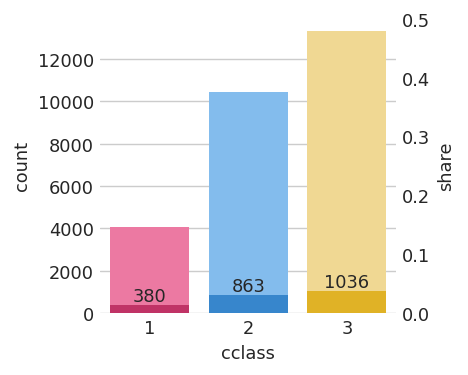

In [252]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.val_sizes = plot_c_classes(val_pairs)
fig.savefig(f'val_cclasses.svg')

In [253]:
# sizes of the sets of positives per species
dict(val_ppis.species.value_counts())

{224308: 1052,
 36329: 739,
 10116: 240,
 39947: 80,
 9913: 62,
 37296: 35,
 7955: 25,
 237561: 17,
 9031: 16,
 8355: 13}

#### save

In [254]:
if not (bak := c.val_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.val_tsv, bak)
val_pairs.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_tsv

PosixPath('apid_validation.tsv')

## HuRI test
#### generate negatives
Read in the files first ...

In [255]:
test = pd.read_csv(c.test_rr_tsv, sep='\t', header=0)
test_seqs = SeqIO.to_dict(SeqIO.parse(c.test_rr_fasta, 'fasta'))
len(test), len(test_seqs)

(19106, 4458)

In [256]:
set(test.species)

{9606}

In [257]:
# reduce the test proteome against the selected val proteome sequences
run_uniqueprot2D(c.pp / '9606_rr_valtest.fasta', c.pp / 'val_extra.fasta',
                 c.pp / '9606_rr_valtest_nr_valextra.fasta',
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json swissprot/9606_rr_valtest.fasta swissprot/val_extra.fasta swissprot/9606_rr_valtest_nr_valextra.fasta
using temporary directory swissprot/9606_rr_valtest3hr29b6r
extract hvals from alignments: 100%|██████████| 5/5 [00:00<00:00, 34.06it/s]
 10135/10491::2596 non-redundant in swissprot/9606_rr_valtest.fasta against swissprot/val_extra.fasta written to swissprot/9606_rr_valtest_nr_valextra.fasta


In [258]:
test_proteome = write_json(read_hash_proteomes(
    {9606}, c.pp, '{sp}_rr_valtest_nr_valextra.fasta'), c.test_proteome)
len(test_proteome[9606])

100%|████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it, batch=9606]


10135

9606: 19106 positives, aim for 191060 negatives


9606: 385508it [02:43, 2364.93it/s]                                                            


9606: 189366/191060 interactome negatives
9606: need 397 extra proteins for 91 hubs; select 397 from 10133 additional proteins. Try to create 3388 interactions, ideally 33.0 per protein.
9606 extras hash: 4D3855A91F34F54F
proteome interactions:
   count  mean   std  min  25%  50%   75%   max
0  397.0  8.53  2.36  3.0  7.0  8.0  10.0  15.0
9606: got 192754 negatives with bias 1.000


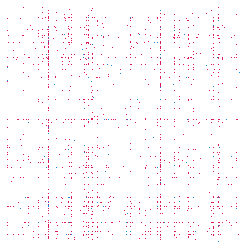

In [259]:
with mpl.rc_context({'figure.dpi': 64}):
    test_ppis, test_negatives, c.test_bias, _ = make_negatives(
        test, c, test_proteome)

In [260]:
test_ppis.head()

,hash_A,hash_B,species,label
0,CRC-000037AE195F7A9D,CRC-82152E496B924EEC,9606,1
1,CRC-000624825E507385,CRC-C116E348E8B7AD2B,9606,1
2,CRC-000624825E507385,CRC-D7C7F6F2CD922775,9606,1
3,CRC-001576EA78C61C85,CRC-0112D12FA71534AE,9606,1
4,CRC-001576EA78C61C85,CRC-03E1033BDF7B1B30,9606,1


In [261]:
test_negatives.head()

,hash_A,hash_B,species,label
0,CRC-000037AE195F7A9D,CRC-2DF01880A22814C9,9606,0
1,CRC-000037AE195F7A9D,CRC-37902FCFD4802294,9606,0
2,CRC-000037AE195F7A9D,CRC-490CDAAC2ABE2A0B,9606,0
3,CRC-000037AE195F7A9D,CRC-4C27D762575E0EA2,9606,0
4,CRC-000037AE195F7A9D,CRC-5DCE56EBA36523C3,9606,0


#### bias
As the test set contains only single species, this is just a number

In [262]:
c.test_bias

0.9998830235890627

#### degrees

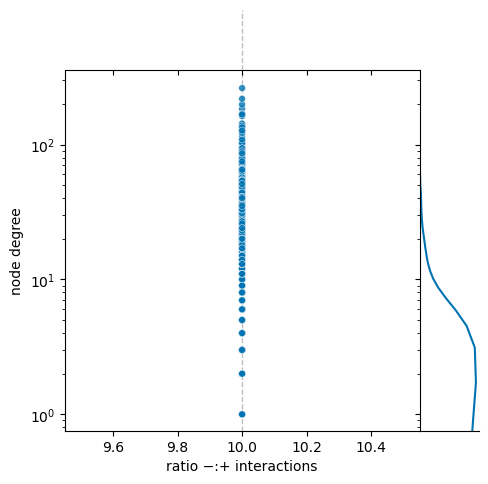

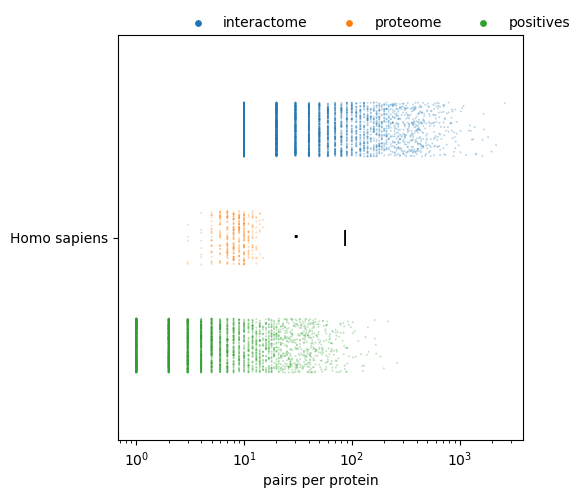

In [279]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, fig2, tdf, tnsp = plot_ratio_degree(
        test_ppis, test_negatives, c.ratio, taxonomy)
fig.savefig('test_ratio_degree.svg')
if fig2 is not None:
    fig2.savefig(f'test_negative_degree.svg')

In [264]:
tdf.loc[tdf.ratio != c.ratio]

,crc_hash,degree,ratio,species


#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [265]:
test_all = pd.concat((test_ppis, test_negatives))
test_all.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_size = len(test_all)
c.test_size, c.test_tsv

(211860, PosixPath('huri_test.tsv'))

In [266]:
assert not set(np.unique(test_ppis.iloc[:, [0, 1]])) - test_seqs.keys()

In [267]:
test_extra = get_proteome_seqs(test_proteome, test_seqs, test_negatives)
_ = SeqIO.write(values_sorted_by_key(test_extra),
                c.pp / 'test_extra.fasta', 'fasta')
c.test_extra = len(test_extra)
c.test_extra, len(test_seqs)

(397, 4458)

In [268]:
test_seqs.update(test_extra)

In [269]:
_ = SeqIO.write(values_sorted_by_key(test_seqs), c.test_fasta, 'fasta')
len(test_seqs), c.test_fasta

(4855, PosixPath('huri_test.fasta'))

In [270]:
assert len(test_all), len(test_seqs) == shrink_both_ways(
    test_all.copy(), test_seqs.copy())

#### cluster against train
Clustering the `HuRI` test set against the `APID` train set gives us **C1-3** labels for the test set.

In [271]:
run_uniqueprot2D(c.test_fasta, c.train_fasta, c.test_c3_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json huri_test.fasta apid_train.fasta huri/huri_test_c3.fasta
using temporary directory huri_testbby97480
extract hvals from alignments: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]
 2718/4855::44785 non-redundant in huri_test.fasta against apid_train.fasta written to huri/huri_test_c3.fasta


#### label PPIs

In [272]:
test_pairs = make_c_classes(c.test_tsv, c.test_c3_fasta, c.test_fasta)

#### class sizes

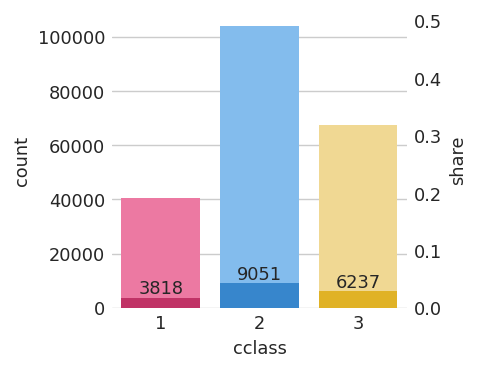

In [273]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.test_sizes = plot_c_classes(test_pairs)
fig.savefig(f'test_cclasses.svg')

#### save

In [274]:
if not (bak := c.test_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.test_tsv, bak)
test_pairs.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_tsv

PosixPath('huri_test.tsv')

In [275]:
with Path(f'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))

{
  "keep_human": false,
  "keep_interspecies": false,
  "accept_homodimers": false,
  "add_proteomes": true,
  "slurm": true,
  "slurm_node_limit": 15,
  "rostclust": "/home/k/kaindll/mambaforge/envs/ppi/bin/rostclust",
  "cwd": "/home/k/kaindll/ppi/ppi_data/results/8000",
  "ap": "apid",
  "hp": "huri",
  "qp": "apid_q1",
  "pp": "swissprot",
  "ip": "apid_isp",
  "dp": "homodimers",
  "min_seq_len": 50,
  "max_seq_len": 1500,
  "hval_config": {
    "shortAlignmentLen": 50,
    "longSeqLen": 180,
    "reduceRandomAlign": false,
    "clusterThreshold": 20
  },
  "hval_config_path": "hval_config.json",
  "seed": 42,
  "ratio": 10.0,
  "strategy": 1,
  "val_set_size": 0.1,
  "val_species": [
    8355,
    10116,
    9031,
    36329,
    39947,
    37296,
    7955,
    224308,
    9913,
    237561
  ],
  "train_species": [
    333760,
    9986,
    83333,
    10377,
    10090,
    85962,
    284812,
    243276,
    10299,
    1392,
    559292,
    3702,
    632,
    2697049,
    7227,
  

---

In [133]:
# _ = plot_test_ratios(test_pairs, c.ratio)

## Re-plot interactome sizes

In [134]:
!pwd

/home/k/kaindll/ppi/data/ppi_dataset/results/7082


In [135]:
def fetch_network_sizes(all_pairs):
    return (pd.DataFrame(all_pairs.species.value_counts().rename('n_ppis'))
            .join(pd.DataFrame(
        all_pairs[['hash_A', 'hash_B', 'species']]
            .melt(id_vars='species')[['value', 'species']]
            .drop_duplicates().groupby('species').size()))
            .reset_index().rename(columns={0: 'n_proteins', 'index': 'species'}))


def fetch_network_sizes_from_tsv(tsv):
    all_pairs = pd.read_csv(tsv, sep='\t', header=0)
    all_pairs = all_pairs.loc[all_pairs.label == 1]
    return fetch_network_sizes(all_pairs)


dfs = list()
for name, path in zip(['train', 'validate', 'test'],
                      [c.train_tsv, c.val_tsv, c.test_tsv]):
    df = fetch_network_sizes_from_tsv(path)
    df['set_name'] = name
    dfs.append(df)
df = pd.concat(dfs)

In [136]:
df

,species,n_ppis,n_proteins,set_name
0,3702,42794,9042,train
1,7227,31832,8522,train
2,559292,25498,5438,train
3,6239,13694,5108,train
4,192222,10863,1272,train
5,10090,4186,3062,train
6,284812,3302,1869,train
7,243276,3294,684,train
8,1111708,2944,1819,train
9,83333,2707,1594,train


In [137]:
before = pd.concat(fetch_network_sizes(_l) for _l in [hash_ppis, huri_hash_ppis])
before

,species,n_ppis,n_proteins
0,3702,42794,9042
1,7227,31832,8522
2,559292,25498,5438
3,6239,13694,5108
4,192222,10863,1272
5,10090,4186,3062
6,284812,3302,1869
7,243276,3294,684
8,1111708,2944,1819
9,83333,2707,1594


In [138]:
df = df.merge(before, on='species', how='left', suffixes=['', '_r']).convert_dtypes()

In [139]:
df = df.merge(taxonomy[['species', 'name']], on='species', how='left')
df.loc[df.species == 9606, 'name'] = 'Homo sapiens'
df = df.sort_values(by='n_ppis')
df

,species,n_ppis,n_proteins,set_name,n_ppis_r,n_proteins_r,name
17,333760,1,2,train,1,2,Human papillomavirus type 16
16,1392,2,4,train,2,4,Bacillus anthracis
14,9986,3,6,train,3,6,Oryctolagus cuniculus
15,2697049,3,4,train,3,4,SARS-CoV 2
13,632,5,9,train,5,9,Yersinia pestis
12,10299,10,16,train,10,16,Human alphaherpesvirus 1 strain 17
27,8355,13,23,validate,43,68,Xenopus laevis
11,10377,14,15,train,14,15,Human herpesvirus 4 strain B95-8
26,9031,16,27,validate,34,54,Gallus gallus
25,237561,17,26,validate,26,40,Candida albicans SC5314


In [140]:
dscript_dir = Path('/home/quirin/PYTHON/ppi-t5/ppi/data/pairs/ref_tsv') if 'kaindl' not in str(session_dir) else Path(
    '/home/k/kaindll/ppi/data/dscript_dir')
!cat "$dscript_dir/human_train.tsv" "$dscript_dir/human_test.tsv" > "$dscript_dir/human.tsv"

In [141]:
dts = dict()
for tsv in dscript_dir.glob('*.tsv'):
    dt = pd.read_csv(tsv, sep='\t', header=None, names=['A', 'B', 'C'])
    dt = dt.loc[dt.C > 0].drop_duplicates()
    dts[tsv.stem] = len(dt), len(np.unique(dt.iloc[:, [0, 1]]))
dts

{'worm_test': (5000, 2384),
 'fly_test': (5000, 2148),
 'yeast_test': (5000, 2344),
 'ecoli_test': (2000, 949),
 'mouse_test': (5000, 3499),
 'human_train': (38346, 7472),
 'human': (47932, 7865),
 'human_test': (9586, 4656)}

In [142]:
!rm "$dscript_dir/human.tsv"

In [143]:
dt = pd.DataFrame(dts).T.reset_index().rename(columns={'index': 'species', 0: 'n_ppis', 1: 'n_proteins'})
dt = dt.loc[~dt.species.str.startswith('human_')]
lookup = {'worm': 6239, 'human': 9606,
          'mouse': 10090, 'ecoli': 83333,
          'yeast': 559292, 'fly': 7227}
dt.species = dt.species.apply(lambda s: lookup[s.split('_')[0]])
dt['set_name'] = 'D-SCRIPT'
dt = dt.merge(taxonomy[['species', 'name']], on='species', how='left')
dt.loc[dt.species == 9606, 'name'] = 'Homo sapiens'
dt

,species,n_ppis,n_proteins,set_name,name
0,6239,5000,2384,D-SCRIPT,Caenorhabditis elegans
1,7227,5000,2148,D-SCRIPT,Drosophila melanogaster
2,559292,5000,2344,D-SCRIPT,Saccharomyces cerevisiae S288C
3,83333,2000,949,D-SCRIPT,Escherichia coli K-12
4,10090,5000,3499,D-SCRIPT,Mus musculus
5,9606,47932,7865,D-SCRIPT,Homo sapiens


In [144]:
dd = pd.concat((df, dt))
# dd = dd.sort_values(by='n_ppis')
dd

,species,n_ppis,n_proteins,set_name,n_ppis_r,n_proteins_r,name
17,333760,1,2,train,1,2,Human papillomavirus type 16
16,1392,2,4,train,2,4,Bacillus anthracis
14,9986,3,6,train,3,6,Oryctolagus cuniculus
15,2697049,3,4,train,3,4,SARS-CoV 2
13,632,5,9,train,5,9,Yersinia pestis
12,10299,10,16,train,10,16,Human alphaherpesvirus 1 strain 17
27,8355,13,23,validate,43,68,Xenopus laevis
11,10377,14,15,train,14,15,Human herpesvirus 4 strain B95-8
26,9031,16,27,validate,34,54,Gallus gallus
25,237561,17,26,validate,26,40,Candida albicans SC5314


In [145]:
def plot_interactome_new(dd, df, xcol='n_ppis', min_x=1, asp=1.4, h=4):
    tax = dd
    df = df.copy().sort_values(by=xcol)
    pal = {'train': '#1E88E5', 'validate': '#D81B60',
           'test': '#FFC107', 'D-SCRIPT': '#004D40'}

    j = sns.catplot(
        data=tax,
        x=xcol,
        y='name',
        hue='set_name',
        palette=pal,
        order=list(df.name)[::-1],
        s=7,
        height=len(set(tax.species)) / h,
        aspect=asp,
        zorder=1000,
        legend=True,
    )
    ax = j.ax
    ax.set(box_aspect=1 / asp)
    j.set(xscale='log', xlabel=None,
          ylim=(None, -.5), xlim=(None, max(tax.n_ppis) * 1.4))

    ax.get_yaxis().set_visible(False)
    j.despine(left=True, bottom=True)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    fk = len(df)
    for i, (idx, row) in enumerate(df.iterrows()):
        sp, nppi, nprot, set_name, nppir, nprotr, name = row
        y = fk - i - 1
        if xcol == 'n_ppis':
            x, x2 = nppi, nppir
        else:
            x, x2 = nprot, nprotr
        if x < x2:
            ax.plot((x, x2), (y, y), markersize=7,
                    color=pal[set_name], marker='o', markerfacecolor=None)
            x = x2
        if sp == 10090:
            x *= 1.2
        # elif sp == 9606:
        #     x *= 2
        ax.text(x * 1.2, y, name, ha='left', va='center', zorder=100)

    ax.xaxis.grid(True, 'minor', linewidth=0, alpha=.2, zorder=0)
    ax.xaxis.grid(True, 'major', linewidth=1, alpha=.4, zorder=0, color='.5')
    sns.move_legend(j, frameon=False, bbox_to_anchor=(min_x, 1),
                    bbox_transform=ax.transData,
                    title=None, ncol=1, loc='upper left')
    j.tight_layout()
    return j


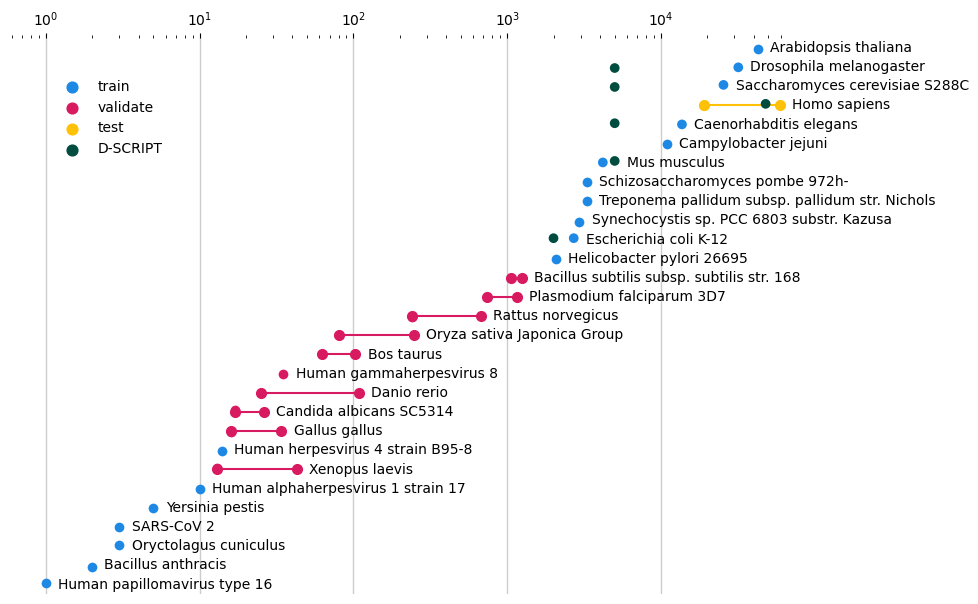

In [146]:
fig = plot_interactome_new(dd, df)
fig.savefig(f'n_ppis.svg')

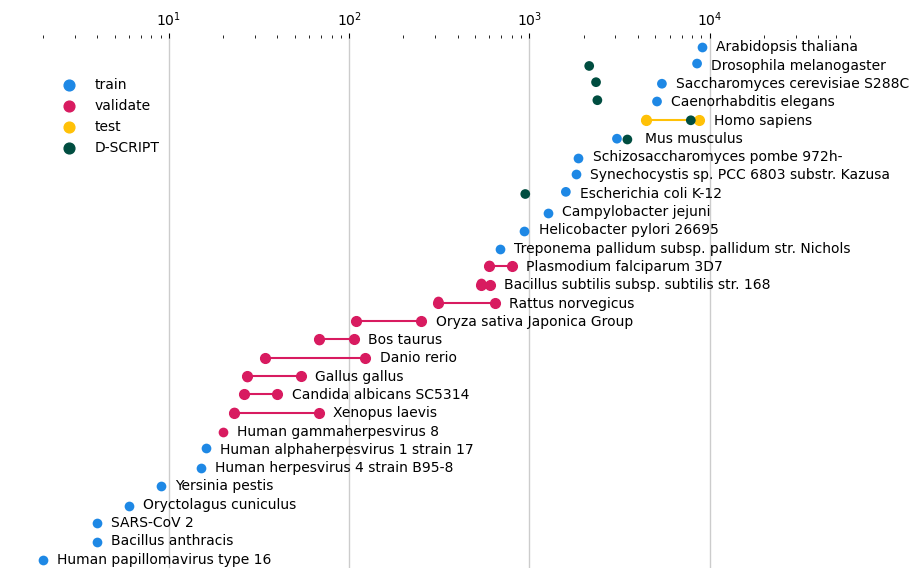

In [147]:
fig = plot_interactome_new(dd, df, xcol='n_proteins', min_x=2, asp=1.6, h=4.6)
fig.savefig(f'n_prots.svg')

In [148]:
print(dd.groupby('set_name')['n_proteins'].sum().to_latex())

\begin{tabular}{lr}
\toprule
{} &  n\_proteins \\
set\_name &             \\
\midrule
D-SCRIPT &       19189 \\
test     &        4458 \\
train    &       39405 \\
validate &        1752 \\
\bottomrule
\end{tabular}



/tmp/user/31049/ipykernel_1628752/2331166548.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dd.groupby('set_name')['n_proteins'].sum().to_latex())


## Find the C-class off-by-one errors

In [ ]:
assert False

In [ ]:
_67 = pd.read_csv('7067_swissprot.txt', sep=' ', header=None, names=['crc', 'none', 'source'])
_67.source = _67.source.str[10:]
_67 = _67[['source', 'crc']].sort_values(by='source')
_67

In [ ]:
_77 = pd.read_csv('7077_swissprot.txt', sep=' ', header=None, names=['crc', 'none', 'source'])
_77.source = _77.source.str[18:]
_77 = _77[['source', 'crc']].sort_values(by='source')
_77

In [ ]:
both = _67.merge(_77, on='source')
both.loc[both.crc_x != both.crc_y]

## Re-plot the dataset bias

In [ ]:
bias = dict()
dts = list()
for tsv in dscript_dir.glob('*.tsv'):
    dt = pd.read_csv(tsv, sep='\t', header=None, names=['A', 'B', 'label'])
    dt['species'] = tsv.stem
    dts.append(dt)
    bias[tsv.stem] = estimate_bias(dt)
bias = pd.DataFrame(bias).T.reset_index().rename(
    columns={'index': 'species', 0: 'bias', 1: 'p'})[['species', 'bias']]
dscript_ppis = pd.concat(dts).convert_dtypes()
dscript_negs, dscript_ppis = [t[1] for t in dscript_ppis.groupby('label')]
bias

In [ ]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_bias(dscript_ppis, dscript_negs, bias, c.ratio, pal=True)
fig.savefig('dataset_bias_dscript.svg')

In [ ]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_bias(pd.concat((train_ppis, val_ppis, test_ppis)),
                    pd.concat((train_negs, val_negs, test_negatives)),
                    pd.concat((train_bias, val_bias)), c.ratio)
fig.savefig('dataset_bias.svg')